# Architecture overview
<hr/>

Entire architecture is based on 3 main components: Data management, Research framework and Execution platform

In general this allows to build not only classical execution/backtest environment but 'strategy fabric' that .....

<h3>Data</h3>
<hr class='l3'/>

 - Low level data (Level1, Level2 and TAS) are stored into KDB/Q+.

 - All data are being collected in realtime using <font color='orange'>connectors</font> implemented in Java. 
     - Supported: IB, FXCM, DukasCopy, AMP futures (any MT5 provider), OKeX, BitMex, Binance, Kraken, Bitstamp, Bitfinex, HitBTC.
     
   
 - Connector is programming module (written in Java) and can be used both for historical data collecting either for providing realtime data feed for trading strategy
 
 - Connector should implement common interface and can be plugged into framework then
 
<h3>Research framework</h3>
<hr class='l3'/>

 - Python based (Jupyter notebooks)
 
 - For trading ideas verification and backtesting
 
 - Actively uses modern ML approaches
 
<h3>Execution platform</h3>
<hr class='l3'/>
 - Fully automatic server side solution
 
 - Provides interface for trading strategies
 
 - Module based structure
 
 - Strategies are written in Java and runnin in fully automatic mode
 
 - It's possible to setup custom schedule (for example stop on Friday and run on Sunday etc)
 
 - Single strategy may work with multiple brokerages/datasources: 
   
   > For example: in the strategy code you can open stocks positions on IB and hedge them on CME futures
   
 - Tracks portfolio with any predefined frequency that gives ability to realtime risks tracking and performance analysis on the fly.

# Access to historical market data (KDB/Q)
<hr/>

All data are being collected into KDB/Q database in realtime using datasource API connectors. It allows easily extend data coverage (just need to code new connector and plug it into framework).

## High level access
<hr class='l2'/>

It's just 2 lines of code to get access to collected data to make it available to use for research / backtest. 

Example of getting Level1 data collected from <font color='green'>InteractiveBrokers API</font> connector for EUR and GBP:

In [ ]:
import ira
%alphalab dark

import qlearn as q
from alpha.utils.stat_helpers import cmp_to_norm

In [9]:
with DataSource('kdb::ib_fx.quotes') as ds:
    fx_data = ds.load_data(['EURUSD', 'GBPUSD'], '2020-01-01', '2020-02-17')

All data automatically converted into pandas DataFrame presentation:
<hr class='l3'/>

In [197]:
fx_data['EURUSD'].head()

,ask,bid,askvol,bidvol
time,,,,
2020-01-02 00:00:00.052,1.12180,1.12188,0.0,0.0
2020-01-02 00:00:00.052,1.12180,1.12188,0.0,1000000.0
2020-01-02 00:00:00.052,1.12192,1.12188,0.0,1000000.0
2020-01-02 00:00:00.052,1.12192,1.12188,500000.0,1000000.0
2020-01-02 00:00:00.185,1.12192,1.12187,500000.0,1000000.0


It can be used for any further analysis
<hr class='l3'/>

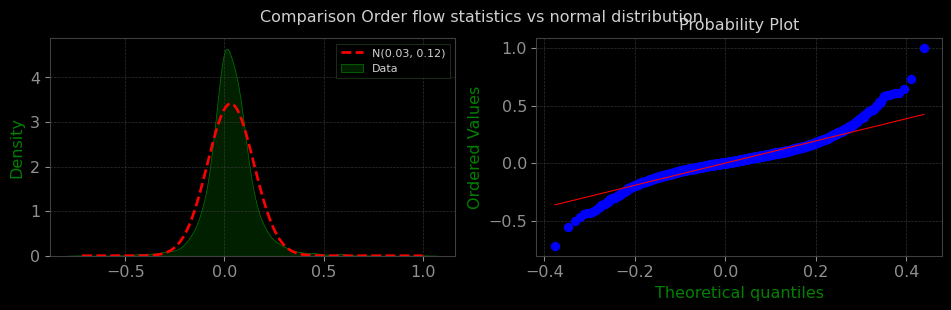

In [89]:
def order_flow(quotes, period='5Min'):
    """
        Calculate raw order flows on each market side
    """
    bdiff, adiff = quotes.bid.diff(), quotes.ask.diff()
    bf = ((bdiff >= 0) * quotes.bidvol - (bdiff <= 0) * quotes.bidvol.shift(1)).rename('BidFlow')
    af = ((adiff <= 0) * quotes.askvol - (adiff >= 0) * quotes.askvol.shift(1)).rename('AskFlow')
    
    f = pd.concat((bf, af), axis=1).fillna(0)
    return ((f['AskFlow'] - f['BidFlow'])/(f['AskFlow'] + f['BidFlow'])).resample(period).mean().dropna()

quotes = fx_data['EURUSD']
fig(12 ,3)

cmp_to_norm(order_flow(data['EURUSD'])); 
plt.suptitle('Comparison Order flow statistics vs normal distribution');

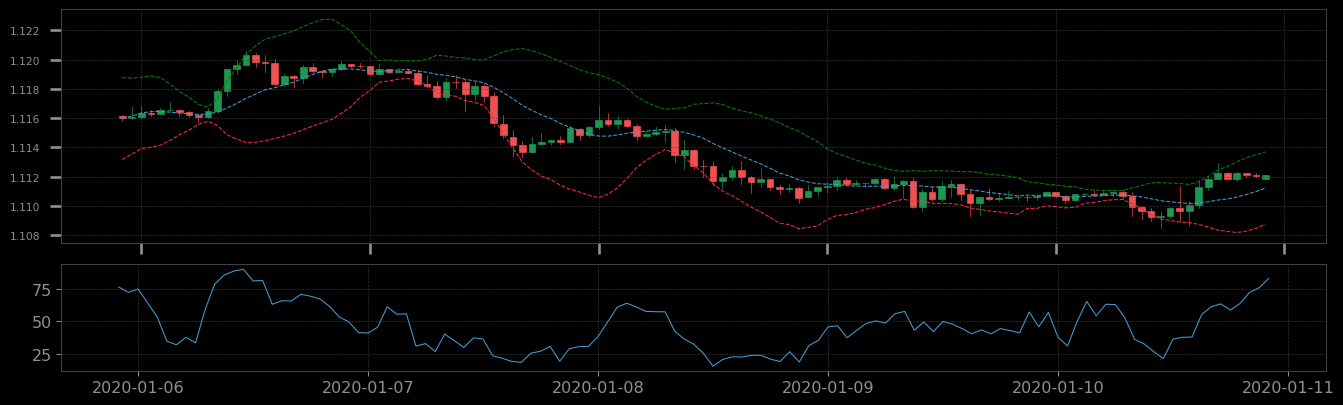

In [40]:
ohlc_1d = ohlc_resample(fx_data, '1h')['EURUSD']
closes = ohlc_1d.close.dropna()

_z = slice('2020-01-04', '2020-01-11')
_bb = bollinger(closes, 12, as_frame=True)
_rsi = rsi(closes, 12)

fig(17, 5); 
sbp(31,1,r=2); ohlc_plot(ohlc_1d[_z]); plt.plot(_bb[_z], '--')
sbp(31,3); plt.plot(_rsi[_z]);

## Low level access

<hr class='l2'/>

Sometimes it needed to run some additional custom statistics directly in Q. 

It's possible to get low level access to KDB server and run any queries directly.

In [90]:
from ira.datasource.KdbConnector import KdbServerController

In [ ]:
ds = DataSource('kdb::ib_fx.quotes')
ctr = KdbServerController.create(ds.get_properties())

Let's calculate VWAP price and aggregate it into 5 minute bars using Q query:

In [176]:
vwap = ctr.exec("""

    select time:date+time, vwap from (
        select vwap:last ((ask*askSize) + (bid*bidSize)) % (askSize + bidSize) by 300 xbar time:time.second, date:`date$time from EURUSD
    )
    
""").set_index('time').sort_index()

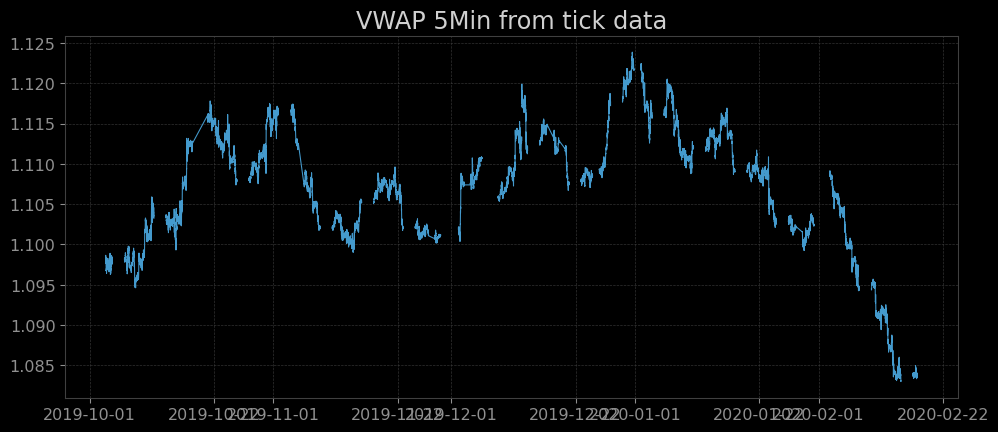

In [181]:
fig(12, 5)
plt.plot(vwap)
plt.title('VWAP 5Min from tick data', size=18);

## Operational database
<hr class='l2'/>

Sometimes it takes too much memory/time to work with KDB/Q directly especially if you need to run for example many fast backtests/experiments on aggregated price data.

For this purposes I use MongoDB database storage (as some handy shelf for most accessible data). This database may be shared accross different servers/users.

For example VWAP data calculated above we could store into MongoDB as pandas dataframe

In [183]:
z_save('My_VWAP_for_research', vwap)

And this data is accessible from any computer where framework is installed just by calling next line:

In [185]:
z_load('My_VWAP_for_research')['data'].head()

,vwap
time,
2019-10-03 16:40:00,1.098609
2019-10-03 16:45:00,1.098444
2019-10-03 16:50:00,1.098532
2019-10-03 16:55:00,1.098293
2019-10-03 17:00:00,1.097871


Actually I'm using this as storage for all backtests/research results to keep it in one place.

# Simulator
<hr/>

There are two backtesters are supported:

 - <font color='orange'>Fast idea tester</font>:
    - highly optimized backtester works with pandas dataframes
    - used for fast estimating of trading setup and finding optimal parameters set
    - friendly to modern machine learning libraries (sklearn, tensorflow etc)
    
 
 - <font color='orange'>Event driven simulator</font> 
    - works on Level1/2 historical data (stored in KDB/Q or any other storage)
    - emulates limit/market/MOC/LOC/PEG orders
    - takes in account liquidity (based on Level1/2 history) and emulates slippage/partial fills/ etc
    - emulates execution latency by generating random timeout using preset latency distribution
    - track transactions costs for all executions and emulates rebates trading
    - provides sophisticated position micro-management techniques:
     - splitting big order by random chunks
     - opening position by quoting market (untill condition are being fullfilled)
     - using predictive micro models for optimal order size management  
    - <font color='green'>Strategy coded for simulator is ready to run on live/paper trading by design</font>
   

## Fast backtester
<hr class='l2'/>

It'd designed to be used as fast trading ideas verification tool. 

It'd be better to show whole process on quick example using simple idea and historical data for crypto market.

As idea we could test this intraday mean-revering trading setup (from [here](https://medium.com/geekculture/the-equilibrium-indicator-profiting-from-mean-reversion-ccecb647b988)):

 - When price expansion from it's mean becomes greater than some threshold we expect reversion to mean and open appropriate position
   - i.e. if price > mean + T we open short or if price < mean - T we open long
   - we will test it on hourly bars intraday data
   - try to find optimal parameters using ML technics 
   - play with different risk managements techniques

As data we will use BTCUSDT data from Binance.


First we need to write standard sklearn predictor. It allows us to use all power of ML libraries.

In [195]:
from sklearn.base import TransformerMixin, BaseEstimator

@q.signal_generator
class Equilibrium(BaseEstimator):
    """
        - Calculate a simple N-period moving average of the market price.
        - Subtract the current market price from its moving average.
        - Calculate a N-period exponential moving average on the subtracted values.

        The result is the N-period Equilibrium Indicator that we will use to generate mean-reverting signals.
    """
    def __init__(self, period, threshold, smoother='sma'):
        self.period = period
        self.smoother = smoother
        self.threshold = threshold
        
    def fit(self, x, y, **kwargs): return self
    
    def predict(self, x):
        c = x[self.market_info_.column]
        # price extension
        dK = smooth(smooth(c, self.smoother, self.period) - c, 'ema', self.period)
        # signals
        return srows(pd.Series(-1, dK[((dK.shift(2) < +self.threshold) & ((dK.shift(1) < +self.threshold) & (dK > +self.threshold)))].index),
                     pd.Series(+1, dK[((dK.shift(2) > -self.threshold) & ((dK.shift(1) > -self.threshold) & (dK < -self.threshold)))].index))

In [193]:
from alpha.utils.tick_loaders import load_data
d = load_data('BINANCE:BTCUSDT')

We will use ML gridsearch approach trying to optimize sharpe ratio 

In [ ]:
eq = q.gridsearch('Eq', Equilibrium(5, 0.001), 
                  q.ReverseSignalsSharpeScoring(commissions='binance'), 
                  d.ohlcs(T), 
                  param_grid = q.permutate_params({
                      'period':    urange(3, 48, 1),
                      'threshold': np.arange(0.001, 0.050, 0.001),
                  }), t_range=['2014', '2019'], 
                  ts_splits=3, verbose=False, return_train_score=False, save=False)

## Simulator 
<hr class='l2'/>
